In [1]:
# Only Video code
# def detect_license_plate(path, collection,reader):
#     cap = cv2.VideoCapture(path)
#     result = {}
#     # read frames
#     frame_number = -1
#     ret = True
#     x=0
#     y=0
#     while ret:
#         ret =False
#         frame_number+=1
#         ret,frame= cap.read()
#         if frame_number==0:
#             (x,y,_) = frame.shape
#             y=int(0.6*y)
#         if ret and frame_number%5==0:
#             try:
#                 results = model.track(frame, persist=True)
#                 cars = results[0].boxes.data.tolist()
#                 track_ids = results[0].boxes.id.int().cpu().tolist()
#                 print(track_ids)
#                 for i in range (len(cars)):
#                     xcar1, ycar1, xcar2, ycar2, track_id, score,object_id = cars[i]
#                     if object_id in vehicles:
#                         car = frame[int(ycar1):int(ycar2), int(xcar1):int(xcar2),:]
#                         license_plates = license_plate_detector(car)[0].boxes.data.tolist()
#                         if len(license_plates)!=0:
#                             x1,y1,x2,y2,score,class_id = license_plates[0]
#                             x1r = int(xcar1 + x1)
#                             y1r = int(ycar1 + y1)
#                             x2r = int(x1r + (x2 - x1))
#                             y2r = int(y1r + (y2 - y1))
#                             if y1r<y or track_ids[i] in result:
#                                 continue
#                             license_plate_crop_ = car[int(y1):int(y2), int(x1):int(x2),:]
#                             thresh_img = align_license_plate(src_img=license_plate_crop_)
#                             if thresh_img is None:
#                                 continue
#                             # thresh_img = imutils.rotate(license_plate_crop_, -30)
#                             # license_plate_crop = align_license_plate(src_img=license_plate_crop_)
#                             # thresh_img =test.preprocess_license_plate(license_plate_crop,is_visualize_steps=True)
#                             license_plate_text , _ = util.read_license_plate(thresh_img,reader)
#                             if license_plate_text and license_plate_text!="" and len(license_plate_text)>4:
#                                 # print("Predictions\n\n")
#                                 # print(track_ids[i],license_plate_text)
#                                 license_plate_text = str(license_plate_text)
#                                 if track_ids[i] not in result:
#                                     temp = datetime.datetime.now().strftime("%H:%M:%S %B %d, %Y")
#                                     result[track_ids[i]] = [license_plate_text,temp]
#             except Exception as e:
#                 print(e)
                
#     # print("Results\n\n\n\n\n")   
#     # print(result)
#     # Log into db
#     # for i in result:
#     #     print(result[i])
#     #     db.insertIntoDatabase(result[i][0],result[i][1])
#     return [result[i] for i in result]

In [2]:
import cv2
path = './Videos/demo.mp4'
image = cv2.imread(path)
print(image.shape)
x,y,_ = image.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [1]:
import cv2
from ultralytics import YOLO
import util
import numpy as np
import db
import test
import imutils
import datetime
from matplotlib import pyplot as plt
# from sort import *
# Loading models

model = YOLO('yolov8n.pt')
license_plate_detector = YOLO('./model/best.pt')

In [2]:
# load video
vehicles = [2,3,5,7]

def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect


def four_points_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped


def getContours(img, orig):
    biggest = np.array([])
    maxArea = 0

    # _, contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 500:
            cv2.drawContours(orig, cnt, -1, (255, 0, 0), 3)
            min_rect = cv2.minAreaRect(cnt)
            approx = cv2.boxPoints(min_rect).astype(int)
            approx = approx[:,np.newaxis,:]
            # peri = cv2.arcLength(cnt, True)
            # approx = cv2.approxPolyDP(cnt,0.02*peri, True)
            if area > maxArea and len(approx) == 4:
            # if area > maxArea:
                biggest = approx
                maxArea = area
                break
    return biggest, orig


def align_license_plate(src_img,is_Visualize=False):
    kernel = np.ones((3,3))
    imgGray = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray,(5,5),1)
    imgCanny = cv2.Canny(imgBlur,150,200)
    imgDial = cv2.dilate(imgCanny,kernel,iterations=2)
    imgThres = cv2.erode(imgDial,kernel,iterations=2)
    imgContour = src_img.copy()
    
    
    
    biggest, contour_img = getContours(imgThres, imgContour)
    # print(biggest)
    if len(biggest) ==0:
        return None
    biggest = np.squeeze(biggest)
    # print(biggest)

    # Visualize if biggest is correct or not
    # imgWarped = src_img.copy()
    # cv2.drawContours(imgWarped, [biggest], 0, (255, 0, 0), 4)

    imgWarped = four_points_transform(src_img, biggest)
    if is_Visualize:
        titles = ['original', 'Blur', 'Canny', 'Dialte', 'Threshold', 'Contours', "Warped" ]
        images = [src_img,  imgBlur, imgCanny, imgDial, imgThres, contour_img, imgWarped]
        
        for i in range(7):
            plt.subplot(3, 3, i+1), plt.imshow(images[i], 'gray')
            plt.title(titles[i])
        
        plt.show()
    return imgWarped

In [9]:
def detect_license_plate(path, collection,reader):
    img = False
    try:
        frame = cv2.imread(path)
        print(frame.shape)
        img=True
    except:
        img = False
    if not img:
        cap = cv2.VideoCapture(path)
        result = {}
        # read frames
        frame_number = -1
        ret = True
        x=0
        y=0
        while ret:
            ret =False
            frame_number+=1
            ret,frame= cap.read()
            if frame_number==0:
                (x,y,_) = frame.shape
                y=int(0.5*y)
            if ret and frame_number%5==0:
                try:
                    results = model.track(frame, persist=True)
                    cars = results[0].boxes.data.tolist()
                    track_ids = results[0].boxes.id.int().cpu().tolist()
                    print(track_ids)
                    for i in range (len(cars)):
                        xcar1, ycar1, xcar2, ycar2, track_id, score,object_id = cars[i]
                        if object_id in vehicles:
                            car = frame[int(ycar1):int(ycar2), int(xcar1):int(xcar2),:]
                            license_plates = license_plate_detector(car)[0].boxes.data.tolist()
                            if len(license_plates)!=0:
                                x1,y1,x2,y2,score,class_id = license_plates[0]
                                x1r = int(xcar1 + x1)
                                y1r = int(ycar1 + y1)
                                x2r = int(x1r + (x2 - x1))
                                y2r = int(y1r + (y2 - y1))
                                if y1r<y or track_ids[i] in result:
                                    continue
                                license_plate_crop_ = car[int(y1):int(y2), int(x1):int(x2),:]
                                thresh_img = align_license_plate(src_img=license_plate_crop_,is_Visualize=True)
                                if thresh_img is None:
                                    continue
                                # thresh_img = imutils.rotate(license_plate_crop_, -30)
                                # license_plate_crop = align_license_plate(src_img=license_plate_crop_)
                                # thresh_img =test.preprocess_license_plate(license_plate_crop,is_visualize_steps=True)
                                license_plate_text , _ = util.read_license_plate(thresh_img,reader)
                                if license_plate_text and license_plate_text!="" and len(license_plate_text)>4:
                                    print("Predictions\n\n")
                                    print(track_ids[i],license_plate_text)
                                    license_plate_text = str(license_plate_text)
                                    if track_ids[i] not in result:
                                        temp = datetime.datetime.now().strftime("%H:%M:%S %B %d, %Y")
                                        result[track_ids[i]] = [license_plate_text,temp]
                except Exception as e:
                    print(e)
                    
        # print("Results\n\n\n\n\n")   
        # print(result)
        # Log into db
        # for i in result:
        #     print(result[i])
        #     db.insertIntoDatabase(result[i][0],result[i][1])
        return [result[i] for i in result]
    if img:
        frame = cv2.imread(path)
        result = {}
        x,y,_ = frame.shape
        y=int(0.55*y)
        license_plates = license_plate_detector(frame)[0].boxes.data.tolist()
        for i in range (len(license_plates)):
                x1,y1,x2,y2,score,class_id = license_plates[i]
                license_plate_crop_ = frame[int(y1):int(y2), int(x1):int(x2),:]
                thresh_img = license_plate_crop_
                try:
                    thresh_img = align_license_plate(src_img=license_plate_crop_)
                    if thresh_img is None:
                        continue
                except:
                    pass
                license_plate_text , _ = util.read_license_plate(thresh_img,reader)
                temp = datetime.datetime.now().strftime("%H:%M:%S %B %d, %Y")
                result[i] = [license_plate_text,temp]
        # Log into db
        # for i in result:
        #     db.insertIntoDatabase(result[i][0],result[i][1])
        var = True
        return [result[i] for i in result]

In [10]:
import easyocr
reader = easyocr.Reader(['en'],gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [11]:
path = './Videos/11.png'
image = detect_license_plate(path,collection="11",reader=reader)

(826, 861, 3)


0: 640x640 1 License_Plate, 346.0ms
Speed: 12.5ms preprocess, 346.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



0: 640x576 1 car, 350.5ms
Speed: 21.8ms preprocess, 350.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)



'NoneType' object has no attribute 'int'


0: 640x576 1 car, 331.0ms
Speed: 9.4ms preprocess, 331.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



'NoneType' object has no attribute 'int'


0: 640x576 1 car, 344.0ms
Speed: 20.9ms preprocess, 344.0ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 640x640 1 License_Plate, 347.1ms
Speed: 1.9ms preprocess, 347.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 car, 345.3ms
Speed: 0.0ms preprocess, 345.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 576x640 1 License_Plate, 380.1ms
Speed: 1.4ms preprocess, 380.1ms inference, 8.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 1 car, 328.2ms
Speed: 11.2ms preprocess, 328.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 1 License_Plate, 361.4ms
Speed: 0.6ms preprocess, 361.4ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 350.2ms
Speed: 9.6ms preprocess, 350.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 1 License_Plate, 300.4ms
Speed: 6.3ms preprocess, 300.4ms inference, 16.4ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 352.2ms
Speed: 3.5ms preprocess, 352.2ms inference, 12.5ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 512x640 1 License_Plate, 350.0ms
Speed: 4.8ms preprocess, 350.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x576 1 car, 342.9ms
Speed: 8.2ms preprocess, 342.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 512x640 (no detections), 290.1ms
Speed: 3.8ms preprocess, 290.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x576 1 car, 325.2ms
Speed: 8.8ms preprocess, 325.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 480x640 (no detections), 322.0ms
Speed: 1.3ms preprocess, 322.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x576 1 car, 344.9ms
Speed: 10.7ms preprocess, 344.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 480x640 (no detections), 260.8ms
Speed: 4.5ms preprocess, 260.8ms inference, 8.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x576 1 car, 340.1ms
Speed: 9.9ms preprocess, 340.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 480x640 (no detections), 270.4ms
Speed: 2.6ms preprocess, 270.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x576 1 car, 328.6ms
Speed: 18.8ms preprocess, 328.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 512x640 (no detections), 269.5ms
Speed: 1.8ms preprocess, 269.5ms inference, 13.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x576 1 car, 340.3ms
Speed: 8.5ms preprocess, 340.3ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 512x640 1 License_Plate, 293.3ms
Speed: 8.9ms preprocess, 293.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x576 1 car, 339.4ms
Speed: 10.3ms preprocess, 339.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 512x640 1 License_Plate, 285.7ms
Speed: 9.7ms preprocess, 285.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x576 1 car, 343.9ms
Speed: 8.8ms preprocess, 343.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 512x640 1 License_Plate, 293.5ms
Speed: 2.3ms preprocess, 293.5ms inference, 4.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x576 1 car, 338.2ms
Speed: 12.4ms preprocess, 338.2ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 (no detections), 313.7ms
Speed: 4.3ms preprocess, 313.7ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 332.3ms
Speed: 8.4ms preprocess, 332.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 (no detections), 310.9ms
Speed: 5.0ms preprocess, 310.9ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 345.2ms
Speed: 10.0ms preprocess, 345.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 1 License_Plate, 280.1ms
Speed: 7.9ms preprocess, 280.1ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 326.7ms
Speed: 16.9ms preprocess, 326.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 (no detections), 296.2ms
Speed: 7.2ms preprocess, 296.2ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 323.3ms
Speed: 11.4ms preprocess, 323.3ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 (no detections), 312.1ms
Speed: 10.0ms preprocess, 312.1ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 343.1ms
Speed: 9.8ms preprocess, 343.1ms inference, 11.5ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 (no detections), 302.4ms
Speed: 8.1ms preprocess, 302.4ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 328.7ms
Speed: 10.9ms preprocess, 328.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 1 License_Plate, 296.8ms
Speed: 7.5ms preprocess, 296.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 348.8ms
Speed: 5.5ms preprocess, 348.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 (no detections), 300.2ms
Speed: 2.7ms preprocess, 300.2ms inference, 15.6ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 340.0ms
Speed: 11.9ms preprocess, 340.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 (no detections), 303.7ms
Speed: 2.0ms preprocess, 303.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 328.3ms
Speed: 11.5ms preprocess, 328.3ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 (no detections), 302.9ms
Speed: 7.5ms preprocess, 302.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 341.6ms
Speed: 8.3ms preprocess, 341.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 1 License_Plate, 296.8ms
Speed: 2.4ms preprocess, 296.8ms inference, 15.5ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 332.8ms
Speed: 0.0ms preprocess, 332.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 1 License_Plate, 296.4ms
Speed: 4.7ms preprocess, 296.4ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 347.0ms
Speed: 8.0ms preprocess, 347.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 1 License_Plate, 301.9ms
Speed: 1.5ms preprocess, 301.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 329.7ms
Speed: 10.5ms preprocess, 329.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 544x640 2 License_Plates, 310.5ms
Speed: 9.0ms preprocess, 310.5ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 335.5ms
Speed: 4.0ms preprocess, 335.5ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 576x640 (no detections), 320.5ms
Speed: 1.1ms preprocess, 320.5ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 1 car, 343.3ms
Speed: 9.7ms preprocess, 343.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 576x640 (no detections), 322.1ms
Speed: 5.1ms preprocess, 322.1ms inference, 8.5ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 1 car, 341.7ms
Speed: 9.1ms preprocess, 341.7ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 576x640 1 License_Plate, 309.6ms
Speed: 8.3ms preprocess, 309.6ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 1 car, 343.6ms
Speed: 8.2ms preprocess, 343.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 576x640 (no detections), 321.2ms
Speed: 6.6ms preprocess, 321.2ms inference, 7.5ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 1 car, 340.0ms
Speed: 12.0ms preprocess, 340.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 576x640 1 License_Plate, 318.6ms
Speed: 0.7ms preprocess, 318.6ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 1 car, 335.2ms
Speed: 9.5ms preprocess, 335.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 576x640 1 License_Plate, 299.0ms
Speed: 6.9ms preprocess, 299.0ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 1 car, 339.4ms
Speed: 8.4ms preprocess, 339.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 576x640 1 License_Plate, 303.7ms
Speed: 1.1ms preprocess, 303.7ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 1 car, 328.8ms
Speed: 12.1ms preprocess, 328.8ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 576x640 (no detections), 310.6ms
Speed: 8.0ms preprocess, 310.6ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 1 car, 345.3ms
Speed: 9.8ms preprocess, 345.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 576x640 2 License_Plates, 321.5ms
Speed: 6.2ms preprocess, 321.5ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 1 car, 324.0ms
Speed: 7.0ms preprocess, 324.0ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 576x640 1 License_Plate, 319.6ms
Speed: 9.1ms preprocess, 319.6ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 1 car, 327.8ms
Speed: 8.8ms preprocess, 327.8ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 608x640 2 License_Plates, 379.4ms
Speed: 3.4ms preprocess, 379.4ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 1 car, 342.0ms
Speed: 8.2ms preprocess, 342.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 608x640 1 License_Plate, 325.1ms
Speed: 8.6ms preprocess, 325.1ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 1 car, 312.0ms
Speed: 12.2ms preprocess, 312.0ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 640x640 2 License_Plates, 329.1ms
Speed: 1.2ms preprocess, 329.1ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 car, 332.0ms
Speed: 8.8ms preprocess, 332.0ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 640x640 1 License_Plate, 352.1ms
Speed: 5.5ms preprocess, 352.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 car, 351.8ms
Speed: 7.5ms preprocess, 351.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 640x640 1 License_Plate, 348.3ms
Speed: 1.5ms preprocess, 348.3ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 car, 347.3ms
Speed: 23.9ms preprocess, 347.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 640x608 1 License_Plate, 336.1ms
Speed: 8.8ms preprocess, 336.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 1 car, 342.3ms
Speed: 10.7ms preprocess, 342.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 640x608 1 License_Plate, 347.7ms
Speed: 7.4ms preprocess, 347.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 1 car, 347.0ms
Speed: 11.1ms preprocess, 347.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14]


0: 640x608 1 License_Plate, 328.4ms
Speed: 6.1ms preprocess, 328.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 2 cars, 325.6ms
Speed: 15.6ms preprocess, 325.6ms inference, 15.5ms postprocess per image at shape (1, 3, 640, 576)



[14, 15]


0: 640x576 1 License_Plate, 329.6ms
Speed: 10.4ms preprocess, 329.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x608 1 License_Plate, 332.0ms
Speed: 3.3ms preprocess, 332.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 2 cars, 331.2ms
Speed: 12.9ms preprocess, 331.2ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 576)



[14, 15]


0: 640x576 1 License_Plate, 325.6ms
Speed: 2.1ms preprocess, 325.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 License_Plate, 325.6ms
Speed: 4.1ms preprocess, 325.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 2 cars, 355.9ms
Speed: 14.0ms preprocess, 355.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14, 15]


0: 640x544 1 License_Plate, 298.4ms
Speed: 13.5ms preprocess, 298.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 2 License_Plates, 312.4ms
Speed: 4.7ms preprocess, 312.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 2 cars, 353.8ms
Speed: 4.3ms preprocess, 353.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x544 1 License_Plate, 160.4ms
Speed: 0.0ms preprocess, 160.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



[14, 15]


0: 640x544 2 License_Plates, 126.4ms
Speed: 0.0ms preprocess, 126.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 2 cars, 1152.0ms
Speed: 12.8ms preprocess, 1152.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14, 15]


0: 640x544 1 License_Plate, 302.0ms
Speed: 4.6ms preprocess, 302.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x512 (no detections), 265.2ms
Speed: 3.9ms preprocess, 265.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 2 cars, 325.6ms
Speed: 8.4ms preprocess, 325.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14, 15]


0: 640x544 1 License_Plate, 292.7ms
Speed: 7.9ms preprocess, 292.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


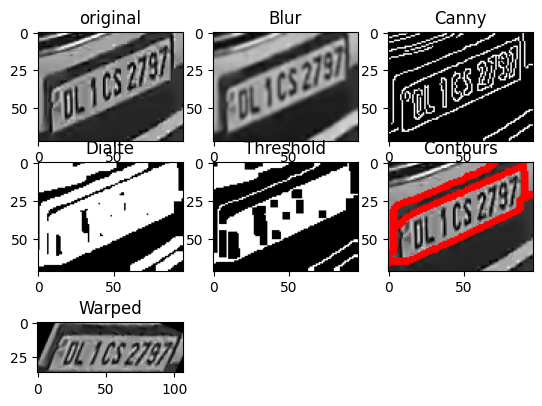

Predictions


14 FUL IC527971


0: 640x480 (no detections), 299.0ms
Speed: 7.1ms preprocess, 299.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 2 cars, 365.4ms
Speed: 0.7ms preprocess, 365.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 576)



[14, 15]


0: 640x512 1 License_Plate, 309.8ms
Speed: 8.5ms preprocess, 309.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 1 License_Plate, 314.3ms
Speed: 3.9ms preprocess, 314.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 2 cars, 388.6ms
Speed: 15.4ms preprocess, 388.6ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 576)



[14, 15]


0: 640x480 1 License_Plate, 300.1ms
Speed: 24.0ms preprocess, 300.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 License_Plate, 306.1ms
Speed: 4.0ms preprocess, 306.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x576 2 cars, 368.8ms
Speed: 13.5ms preprocess, 368.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 576)



[14, 15]


0: 640x384 1 License_Plate, 283.7ms
Speed: 0.0ms preprocess, 283.7ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 1 License_Plate, 266.5ms
Speed: 1.6ms preprocess, 266.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 1 car, 1 parking meter, 345.9ms
Speed: 8.0ms preprocess, 345.9ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 576)



[14, 15]


0: 640x480 1 License_Plate, 273.8ms
Speed: 3.7ms preprocess, 273.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 1 car, 1 train, 371.6ms
Speed: 12.5ms preprocess, 371.6ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 576)



[14, 15]


0: 640x512 1 License_Plate, 307.1ms
Speed: 0.0ms preprocess, 307.1ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 1 train, 346.8ms
Speed: 10.2ms preprocess, 346.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14, 15]


0: 640x512 1 License_Plate, 293.3ms
Speed: 0.0ms preprocess, 293.3ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 2 cars, 346.0ms
Speed: 15.6ms preprocess, 346.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[14, 15]


0: 640x320 (no detections), 237.0ms
Speed: 15.6ms preprocess, 237.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x512 1 License_Plate, 273.5ms
Speed: 4.5ms preprocess, 273.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 346.3ms
Speed: 0.0ms preprocess, 346.3ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)



[15]


0: 640x544 1 License_Plate, 338.4ms
Speed: 0.0ms preprocess, 338.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 1 car, 348.1ms
Speed: 15.1ms preprocess, 348.1ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 576)



[15]


0: 640x544 1 License_Plate, 314.2ms
Speed: 5.7ms preprocess, 314.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 1 car, 329.4ms
Speed: 5.0ms preprocess, 329.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 576)



[15]


0: 640x512 1 License_Plate, 281.3ms
Speed: 0.0ms preprocess, 281.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 321.4ms
Speed: 13.9ms preprocess, 321.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[15]


0: 640x512 1 License_Plate, 284.3ms
Speed: 6.7ms preprocess, 284.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 378.0ms
Speed: 0.0ms preprocess, 378.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[15]


0: 640x512 1 License_Plate, 298.7ms
Speed: 15.6ms preprocess, 298.7ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 340.0ms
Speed: 11.2ms preprocess, 340.0ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 576)



[15]


0: 640x480 1 License_Plate, 268.2ms
Speed: 0.0ms preprocess, 268.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 1 car, 344.5ms
Speed: 16.3ms preprocess, 344.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[15]


0: 640x480 1 License_Plate, 274.0ms
Speed: 8.5ms preprocess, 274.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


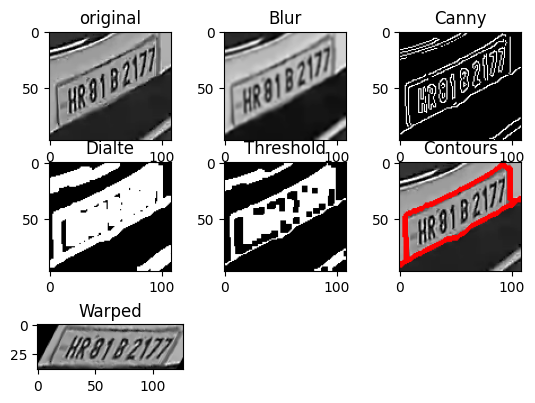

Predictions


15 HR81821711


0: 640x576 1 parking meter, 334.0ms
Speed: 15.9ms preprocess, 334.0ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 576)



[15]


0: 640x576 1 parking meter, 348.0ms
Speed: 15.5ms preprocess, 348.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[15]


0: 640x576 1 train, 362.4ms
Speed: 0.0ms preprocess, 362.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[15]


0: 640x576 1 train, 360.6ms
Speed: 15.5ms preprocess, 360.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[15]


0: 640x576 1 person, 1 motorcycle, 341.3ms
Speed: 16.7ms preprocess, 341.3ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 576)



'NoneType' object has no attribute 'int'


0: 640x576 5 persons, 347.0ms
Speed: 15.7ms preprocess, 347.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



'NoneType' object has no attribute 'int'


0: 640x576 6 persons, 1 backpack, 346.9ms
Speed: 15.6ms preprocess, 346.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



'NoneType' object has no attribute 'int'


0: 640x576 8 persons, 1 car, 346.2ms
Speed: 15.7ms preprocess, 346.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



'NoneType' object has no attribute 'int'


0: 640x576 1 car, 345.4ms
Speed: 16.0ms preprocess, 345.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[16]


0: 608x640 1 License_Plate, 345.7ms
Speed: 15.6ms preprocess, 345.7ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 1 car, 346.4ms
Speed: 0.0ms preprocess, 346.4ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 576)



[16]


0: 608x640 1 License_Plate, 363.5ms
Speed: 15.6ms preprocess, 363.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 1 car, 362.1ms
Speed: 5.5ms preprocess, 362.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[16]


0: 640x640 2 License_Plates, 374.3ms
Speed: 2.6ms preprocess, 374.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 car, 330.1ms
Speed: 16.6ms preprocess, 330.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[16]


0: 640x608 1 License_Plate, 344.3ms
Speed: 18.8ms preprocess, 344.3ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 1 car, 354.4ms
Speed: 21.6ms preprocess, 354.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[16]


0: 640x544 1 License_Plate, 314.4ms
Speed: 0.0ms preprocess, 314.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 1 car, 361.4ms
Speed: 15.6ms preprocess, 361.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[16]


0: 640x512 1 License_Plate, 292.4ms
Speed: 6.9ms preprocess, 292.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 347.3ms
Speed: 15.7ms preprocess, 347.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[16]


0: 640x512 1 License_Plate, 298.7ms
Speed: 15.0ms preprocess, 298.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 346.1ms
Speed: 0.9ms preprocess, 346.1ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)



[16]


0: 640x512 1 License_Plate, 298.6ms
Speed: 0.0ms preprocess, 298.6ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 380.3ms
Speed: 15.6ms preprocess, 380.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[16]


0: 640x512 2 License_Plates, 297.8ms
Speed: 0.0ms preprocess, 297.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 340.0ms
Speed: 21.1ms preprocess, 340.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[16]


0: 640x512 1 License_Plate, 298.9ms
Speed: 15.6ms preprocess, 298.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 329.8ms
Speed: 14.5ms preprocess, 329.8ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)



[16]


0: 640x480 1 License_Plate, 282.1ms
Speed: 15.5ms preprocess, 282.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 1 car, 346.2ms
Speed: 9.5ms preprocess, 346.2ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)



[16]


0: 640x480 1 License_Plate, 269.3ms
Speed: 0.0ms preprocess, 269.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 2 cars, 358.4ms
Speed: 19.1ms preprocess, 358.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[16, 19]


0: 640x512 1 License_Plate, 292.7ms
Speed: 8.0ms preprocess, 292.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


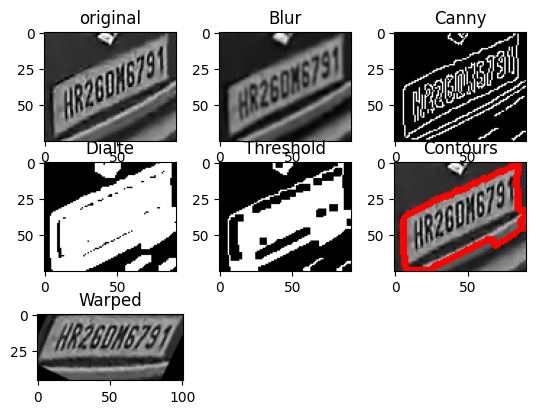

Predictions


16 Hr260h6791


0: 640x608 1 License_Plate, 345.8ms
Speed: 0.0ms preprocess, 345.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 2 cars, 346.0ms
Speed: 15.6ms preprocess, 346.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[16, 19]


0: 640x480 1 License_Plate, 281.6ms
Speed: 1.1ms preprocess, 281.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 1 License_Plate, 361.6ms
Speed: 0.0ms preprocess, 361.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 car, 1 motorcycle, 345.1ms
Speed: 16.1ms preprocess, 345.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[16, 19]


0: 640x384 (no detections), 220.1ms
Speed: 0.0ms preprocess, 220.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 608x640 (no detections), 345.9ms
Speed: 15.6ms preprocess, 345.9ms inference, 15.6ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 1 car, 1 train, 363.1ms
Speed: 31.3ms preprocess, 363.1ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 576)



[16, 19]


0: 576x640 (no detections), 338.6ms
Speed: 15.6ms preprocess, 338.6ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 2 cars, 346.2ms
Speed: 15.8ms preprocess, 346.2ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 576)



[16, 19]


0: 640x288 (no detections), 212.0ms
Speed: 0.0ms preprocess, 212.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)

0: 576x640 (no detections), 329.9ms
Speed: 0.0ms preprocess, 329.9ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 1 car, 315.7ms
Speed: 0.0ms preprocess, 315.7ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 608x640 (no detections), 314.1ms
Speed: 15.0ms preprocess, 314.1ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 1 car, 329.7ms
Speed: 15.6ms preprocess, 329.7ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x640 1 License_Plate, 343.2ms
Speed: 18.0ms preprocess, 343.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 car, 334.4ms
Speed: 11.5ms preprocess, 334.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x608 1 License_Plate, 313.8ms
Speed: 15.6ms preprocess, 313.8ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 1 car, 329.9ms
Speed: 15.7ms preprocess, 329.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x640 1 License_Plate, 361.1ms
Speed: 0.0ms preprocess, 361.1ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 car, 329.8ms
Speed: 15.7ms preprocess, 329.8ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x576 1 License_Plate, 298.7ms
Speed: 16.0ms preprocess, 298.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 car, 334.1ms
Speed: 15.7ms preprocess, 334.1ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x640 1 License_Plate, 345.8ms
Speed: 0.0ms preprocess, 345.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 car, 330.2ms
Speed: 16.8ms preprocess, 330.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x640 1 License_Plate, 362.0ms
Speed: 15.6ms preprocess, 362.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 car, 344.4ms
Speed: 16.2ms preprocess, 344.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x608 1 License_Plate, 330.4ms
Speed: 15.6ms preprocess, 330.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 1 car, 330.1ms
Speed: 12.5ms preprocess, 330.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x608 1 License_Plate, 345.5ms
Speed: 15.6ms preprocess, 345.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 1 car, 342.1ms
Speed: 15.6ms preprocess, 342.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x576 1 License_Plate, 321.6ms
Speed: 7.7ms preprocess, 321.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 car, 329.8ms
Speed: 6.0ms preprocess, 329.8ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x512 1 License_Plate, 283.0ms
Speed: 0.0ms preprocess, 283.0ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 335.4ms
Speed: 10.0ms preprocess, 335.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x512 1 License_Plate, 267.9ms
Speed: 7.5ms preprocess, 267.9ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 512)


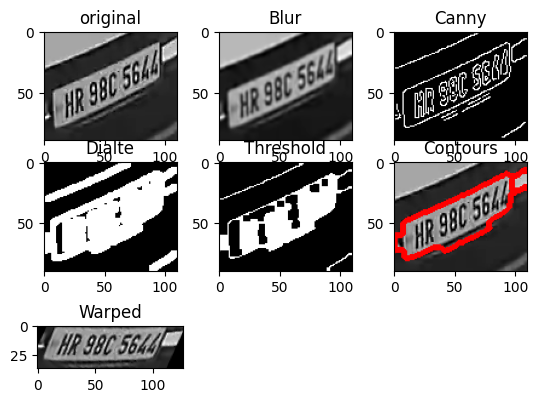

Predictions


19 HR 980,56ky


0: 640x576 1 car, 339.1ms
Speed: 0.0ms preprocess, 339.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x480 1 License_Plate, 272.2ms
Speed: 4.1ms preprocess, 272.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 1 car, 329.3ms
Speed: 10.0ms preprocess, 329.3ms inference, 16.3ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x416 1 License_Plate, 300.8ms
Speed: 15.5ms preprocess, 300.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x576 1 train, 356.1ms
Speed: 22.4ms preprocess, 356.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x576 1 car, 325.7ms
Speed: 12.6ms preprocess, 325.7ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)



[19]


0: 640x352 1 License_Plate, 236.2ms
Speed: 0.0ms preprocess, 236.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x576 2 cars, 347.8ms
Speed: 16.4ms preprocess, 347.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)



[21, 22]


0: 640x544 1 License_Plate, 313.9ms
Speed: 4.5ms preprocess, 313.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x480 (no detections), 262.7ms
Speed: 19.7ms preprocess, 262.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 2 cars, 345.1ms
Speed: 15.7ms preprocess, 345.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[21, 22]


0: 640x544 1 License_Plate, 313.0ms
Speed: 0.0ms preprocess, 313.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)

0: 640x512 (no detections), 300.3ms
Speed: 0.0ms preprocess, 300.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 2 cars, 323.7ms
Speed: 0.0ms preprocess, 323.7ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 576)



[21, 22]


0: 640x544 1 License_Plate, 307.9ms
Speed: 8.0ms preprocess, 307.9ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x512 (no detections), 290.6ms
Speed: 0.0ms preprocess, 290.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 2 cars, 327.2ms
Speed: 16.0ms preprocess, 327.2ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 576)



[21, 22]


0: 640x512 1 License_Plate, 234.2ms
Speed: 7.3ms preprocess, 234.2ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x544 (no detections), 291.5ms
Speed: 16.0ms preprocess, 291.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 2 cars, 328.4ms
Speed: 4.4ms preprocess, 328.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 576)



[21, 22]


0: 640x512 1 License_Plate, 282.9ms
Speed: 0.0ms preprocess, 282.9ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 512)


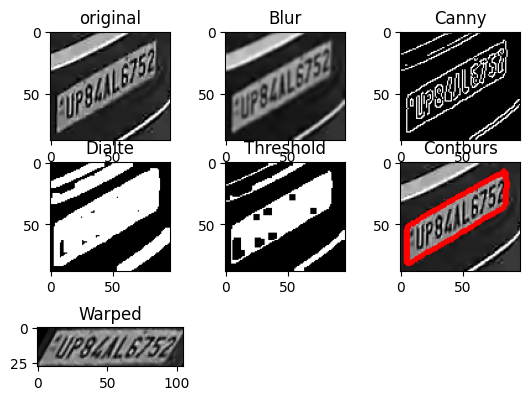

Predictions


21 FUPBG4AL6752


0: 640x576 (no detections), 313.8ms
Speed: 7.1ms preprocess, 313.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 2 cars, 334.1ms
Speed: 15.6ms preprocess, 334.1ms inference, 11.5ms postprocess per image at shape (1, 3, 640, 576)



[21, 22]


0: 640x448 1 License_Plate, 316.6ms
Speed: 0.0ms preprocess, 316.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x576 (no detections), 313.5ms
Speed: 12.5ms preprocess, 313.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 2 cars, 341.2ms
Speed: 15.7ms preprocess, 341.2ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 576)



[21, 22]


0: 640x352 1 License_Plate, 209.5ms
Speed: 3.2ms preprocess, 209.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x576 1 License_Plate, 328.9ms
Speed: 7.5ms preprocess, 328.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 2 cars, 346.7ms
Speed: 0.0ms preprocess, 346.7ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 576)



[21, 22]


0: 640x320 1 License_Plate, 228.9ms
Speed: 15.6ms preprocess, 228.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x544 1 License_Plate, 312.1ms
Speed: 0.0ms preprocess, 312.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 3 cars, 345.7ms
Speed: 16.0ms preprocess, 345.7ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)

0: 640x288 (no detections), 143.4ms
Speed: 8.1ms preprocess, 143.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 288)



[21, 22, 23]


0: 640x544 1 License_Plate, 364.6ms
Speed: 0.0ms preprocess, 364.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 272.9ms
Speed: 15.6ms preprocess, 272.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 2 cars, 342.2ms
Speed: 6.5ms preprocess, 342.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[22, 23]


0: 640x512 1 License_Plate, 312.5ms
Speed: 0.0ms preprocess, 312.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x544 (no detections), 308.9ms
Speed: 0.0ms preprocess, 308.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 2 cars, 414.3ms
Speed: 12.7ms preprocess, 414.3ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 576)



[22, 23]


0: 640x544 1 License_Plate, 300.2ms
Speed: 15.0ms preprocess, 300.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 300.5ms
Speed: 0.0ms preprocess, 300.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 2 cars, 360.7ms
Speed: 10.9ms preprocess, 360.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[22, 23]


0: 640x512 1 License_Plate, 288.4ms
Speed: 7.3ms preprocess, 288.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 (no detections), 310.0ms
Speed: 7.2ms preprocess, 310.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 2 cars, 336.5ms
Speed: 11.1ms preprocess, 336.5ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)



[22, 23]


0: 640x512 1 License_Plate, 293.4ms
Speed: 8.2ms preprocess, 293.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 (no detections), 328.7ms
Speed: 3.8ms preprocess, 328.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 2 cars, 365.0ms
Speed: 2.7ms preprocess, 365.0ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 576)



[22, 23]


0: 640x512 1 License_Plate, 304.0ms
Speed: 9.0ms preprocess, 304.0ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x544 (no detections), 320.0ms
Speed: 8.1ms preprocess, 320.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 1 car, 1 suitcase, 360.7ms
Speed: 13.1ms preprocess, 360.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 576)



[22, 23]


0: 640x480 1 License_Plate, 286.6ms
Speed: 6.0ms preprocess, 286.6ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 480)


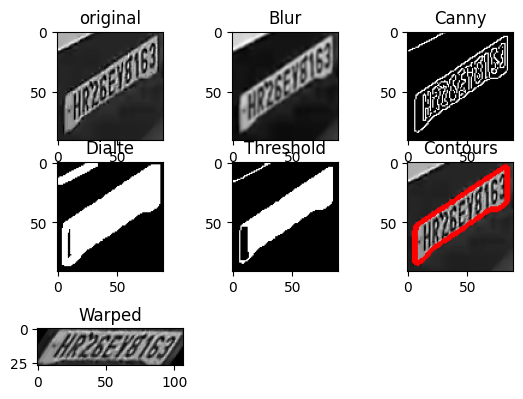

Predictions


22 {822seyg163


0: 640x576 1 car, 1 suitcase, 328.4ms
Speed: 16.4ms preprocess, 328.4ms inference, 15.9ms postprocess per image at shape (1, 3, 640, 576)



[22, 23]


0: 640x384 (no detections), 253.0ms
Speed: 9.2ms preprocess, 253.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x576 2 cars, 397.9ms
Speed: 10.5ms preprocess, 397.9ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 576)



[22, 23]


0: 640x320 (no detections), 200.9ms
Speed: 3.3ms preprocess, 200.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x544 (no detections), 327.2ms
Speed: 16.9ms preprocess, 327.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 2 cars, 355.6ms
Speed: 13.3ms preprocess, 355.6ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 576)



[22, 23]


0: 640x256 (no detections), 195.4ms
Speed: 3.4ms preprocess, 195.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x544 (no detections), 326.4ms
Speed: 6.2ms preprocess, 326.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 2 cars, 338.8ms
Speed: 8.3ms preprocess, 338.8ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 576)

0: 640x192 (no detections), 164.9ms
Speed: 3.1ms preprocess, 164.9ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 192)



[22, 23]


0: 640x544 1 License_Plate, 331.4ms
Speed: 7.8ms preprocess, 331.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 1 car, 359.9ms
Speed: 10.1ms preprocess, 359.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 576)



[23]


0: 640x512 1 License_Plate, 297.6ms
Speed: 7.8ms preprocess, 297.6ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 372.5ms
Speed: 9.7ms preprocess, 372.5ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 576)



[23]


0: 640x512 (no detections), 290.4ms
Speed: 4.1ms preprocess, 290.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 2 cars, 343.4ms
Speed: 6.8ms preprocess, 343.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 576)



[23, 25]


0: 640x480 (no detections), 288.0ms
Speed: 6.7ms preprocess, 288.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 608x640 (no detections), 378.3ms
Speed: 12.7ms preprocess, 378.3ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 1 car, 1 train, 329.9ms
Speed: 10.1ms preprocess, 329.9ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 576)



[23, 25]


0: 544x640 (no detections), 369.9ms
Speed: 7.3ms preprocess, 369.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 2 cars, 342.0ms
Speed: 5.6ms preprocess, 342.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x288 (no detections), 167.6ms
Speed: 4.7ms preprocess, 167.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)



[23, 25]


0: 512x640 (no detections), 339.3ms
Speed: 0.5ms preprocess, 339.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x576 1 car, 335.9ms
Speed: 10.2ms preprocess, 335.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 576)



[25]


0: 544x640 (no detections), 305.1ms
Speed: 12.6ms preprocess, 305.1ms inference, 5.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 349.2ms
Speed: 10.8ms preprocess, 349.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[25]


0: 544x640 (no detections), 298.1ms
Speed: 4.8ms preprocess, 298.1ms inference, 5.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 1 car, 344.2ms
Speed: 10.5ms preprocess, 344.2ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 576)



[25]


0: 576x640 (no detections), 369.9ms
Speed: 10.0ms preprocess, 369.9ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 1 car, 338.2ms
Speed: 6.7ms preprocess, 338.2ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 576)



[25]


0: 640x640 (no detections), 410.6ms
Speed: 5.1ms preprocess, 410.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 car, 340.5ms
Speed: 10.0ms preprocess, 340.5ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 576)



[25]


0: 640x640 1 License_Plate, 339.9ms
Speed: 6.7ms preprocess, 339.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 car, 339.9ms
Speed: 9.0ms preprocess, 339.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[25]


0: 640x608 1 License_Plate, 397.0ms
Speed: 2.1ms preprocess, 397.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 1 car, 310.8ms
Speed: 7.5ms preprocess, 310.8ms inference, 17.8ms postprocess per image at shape (1, 3, 640, 576)



[25]


0: 640x576 1 License_Plate, 332.9ms
Speed: 7.6ms preprocess, 332.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 car, 328.5ms
Speed: 4.1ms preprocess, 328.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[25]


0: 640x576 1 License_Plate, 332.7ms
Speed: 10.4ms preprocess, 332.7ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 car, 347.4ms
Speed: 10.6ms preprocess, 347.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[25]


0: 640x544 1 License_Plate, 302.6ms
Speed: 6.3ms preprocess, 302.6ms inference, 10.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 1 car, 333.1ms
Speed: 10.0ms preprocess, 333.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[25]


0: 640x544 1 License_Plate, 311.1ms
Speed: 6.2ms preprocess, 311.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 1 car, 348.1ms
Speed: 4.8ms preprocess, 348.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[25]


0: 640x512 1 License_Plate, 287.6ms
Speed: 10.4ms preprocess, 287.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 342.6ms
Speed: 9.4ms preprocess, 342.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 576)



[25]


0: 640x512 1 License_Plate, 291.0ms
Speed: 7.8ms preprocess, 291.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 2 cars, 334.2ms
Speed: 8.3ms preprocess, 334.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[25, 26]


0: 640x512 1 License_Plate, 269.3ms
Speed: 7.3ms preprocess, 269.3ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x608 (no detections), 339.2ms
Speed: 4.7ms preprocess, 339.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 2 cars, 329.2ms
Speed: 9.4ms preprocess, 329.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[25, 26]


0: 640x512 1 License_Plate, 281.7ms
Speed: 4.7ms preprocess, 281.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


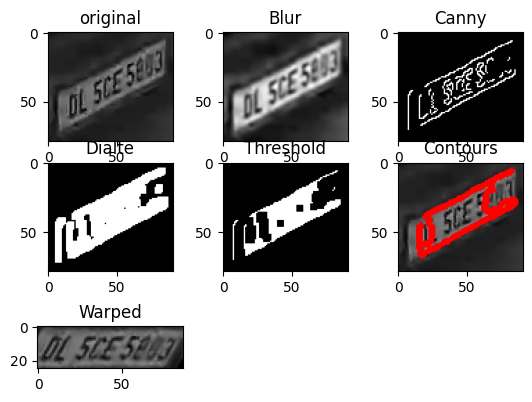

Predictions


25 DL SCE590]


0: 640x640 (no detections), 346.7ms
Speed: 13.4ms preprocess, 346.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 2 cars, 310.5ms
Speed: 17.7ms preprocess, 310.5ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 576)



[25, 26]


0: 640x512 1 License_Plate, 296.1ms
Speed: 4.8ms preprocess, 296.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 608x640 (no detections), 354.2ms
Speed: 0.9ms preprocess, 354.2ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 2 cars, 332.1ms
Speed: 7.5ms preprocess, 332.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[25, 26]


0: 640x480 1 License_Plate, 277.3ms
Speed: 8.0ms preprocess, 277.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 608x640 (no detections), 331.0ms
Speed: 7.6ms preprocess, 331.0ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 1 car, 1 bus, 340.9ms
Speed: 4.0ms preprocess, 340.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[25, 26]


0: 640x448 1 License_Plate, 282.9ms
Speed: 1.6ms preprocess, 282.9ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 448)

0: 608x640 (no detections), 329.6ms
Speed: 6.1ms preprocess, 329.6ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 1 car, 1 bus, 333.8ms
Speed: 6.2ms preprocess, 333.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[25, 26]


0: 640x384 (no detections), 260.4ms
Speed: 1.8ms preprocess, 260.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 608x640 (no detections), 311.9ms
Speed: 14.7ms preprocess, 311.9ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 1 car, 1 train, 354.0ms
Speed: 6.4ms preprocess, 354.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[25, 26]


0: 608x640 (no detections), 349.4ms
Speed: 9.4ms preprocess, 349.4ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 2 cars, 343.5ms
Speed: 15.5ms preprocess, 343.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[25, 26]


0: 640x320 (no detections), 218.9ms
Speed: 0.0ms preprocess, 218.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x640 1 License_Plate, 342.2ms
Speed: 5.0ms preprocess, 342.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 2 cars, 321.2ms
Speed: 11.5ms preprocess, 321.2ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)

0: 640x288 (no detections), 153.4ms
Speed: 6.4ms preprocess, 153.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)



[25, 26]


0: 640x640 1 License_Plate, 347.4ms
Speed: 7.5ms preprocess, 347.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 2 cars, 349.7ms
Speed: 9.6ms preprocess, 349.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 576)

0: 640x224 (no detections), 167.1ms
Speed: 7.5ms preprocess, 167.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 224)


[25, 26]



0: 640x640 1 License_Plate, 325.4ms
Speed: 12.3ms preprocess, 325.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 car, 342.9ms
Speed: 0.0ms preprocess, 342.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x608 1 License_Plate, 324.5ms
Speed: 7.1ms preprocess, 324.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 1 car, 356.7ms
Speed: 7.1ms preprocess, 356.7ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x576 1 License_Plate, 322.4ms
Speed: 6.1ms preprocess, 322.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 car, 340.0ms
Speed: 13.2ms preprocess, 340.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x576 1 License_Plate, 555.9ms
Speed: 8.1ms preprocess, 555.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 car, 444.5ms
Speed: 11.1ms preprocess, 444.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x576 1 License_Plate, 545.1ms
Speed: 8.0ms preprocess, 545.1ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 car, 417.8ms
Speed: 16.0ms preprocess, 417.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x576 1 License_Plate, 379.8ms
Speed: 9.4ms preprocess, 379.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 car, 353.5ms
Speed: 16.0ms preprocess, 353.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x544 1 License_Plate, 356.0ms
Speed: 16.1ms preprocess, 356.0ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 1 truck, 351.4ms
Speed: 13.4ms preprocess, 351.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x512 1 License_Plate, 313.7ms
Speed: 8.0ms preprocess, 313.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 1 car, 341.3ms
Speed: 8.0ms preprocess, 341.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x480 1 License_Plate, 281.2ms
Speed: 0.0ms preprocess, 281.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 1 car, 368.1ms
Speed: 0.0ms preprocess, 368.1ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x480 1 License_Plate, 282.2ms
Speed: 0.0ms preprocess, 282.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 1 car, 339.3ms
Speed: 15.0ms preprocess, 339.3ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x480 1 License_Plate, 264.0ms
Speed: 8.0ms preprocess, 264.0ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 1 car, 340.4ms
Speed: 15.5ms preprocess, 340.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x480 1 License_Plate, 282.8ms
Speed: 8.5ms preprocess, 282.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


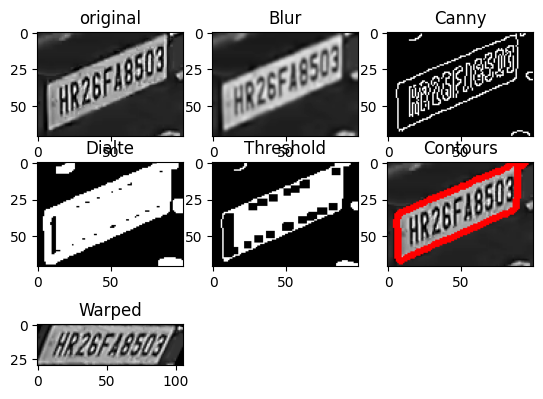

Predictions


26 HR26F48503


0: 640x576 1 car, 328.0ms
Speed: 10.6ms preprocess, 328.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x480 1 License_Plate, 276.5ms
Speed: 0.0ms preprocess, 276.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 1 car, 349.5ms
Speed: 15.6ms preprocess, 349.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x416 1 License_Plate, 286.8ms
Speed: 13.6ms preprocess, 286.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x576 1 train, 346.3ms
Speed: 13.1ms preprocess, 346.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x576 1 bus, 367.1ms
Speed: 2.5ms preprocess, 367.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x320 (no detections), 200.1ms


[26]


Speed: 7.7ms preprocess, 200.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x576 1 train, 364.6ms
Speed: 6.1ms preprocess, 364.6ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 576)



[26]


0: 640x576 (no detections), 348.0ms
Speed: 0.0ms preprocess, 348.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



'NoneType' object has no attribute 'int'


0: 640x576 (no detections), 342.8ms
Speed: 15.0ms preprocess, 342.8ms inference, 11.5ms postprocess per image at shape (1, 3, 640, 576)



'NoneType' object has no attribute 'int'


0: 640x576 (no detections), 369.3ms
Speed: 16.1ms preprocess, 369.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



'NoneType' object has no attribute 'int'


0: 640x576 (no detections), 344.6ms
Speed: 15.6ms preprocess, 344.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



'NoneType' object has no attribute 'int'


0: 640x576 (no detections), 354.0ms
Speed: 9.1ms preprocess, 354.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


'NoneType' object has no attribute 'int'


In [12]:
path = './Videos/full.avi'
videos = detect_license_plate(path,"1",reader)

In [13]:
print(image)

[['FUP8L1L6752', '11:46:25 October 20, 2023']]


In [14]:
print(videos)

[['FUL IC527971', '11:47:11 October 20, 2023'], ['HR81821711', '11:47:25 October 20, 2023'], ['Hr260h6791', '11:47:42 October 20, 2023'], ['HR 980,56ky', '11:47:58 October 20, 2023'], ['FUPBG4AL6752', '11:48:07 October 20, 2023'], ['{822seyg163', '11:48:20 October 20, 2023'], ['DL SCE590]', '11:48:43 October 20, 2023'], ['HR26F48503', '11:49:03 October 20, 2023']]
